
## Importing Necessary Libraries


In [1]:
import os
import cv2
import dlib
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Pretrained Models for Landmark detection

In [2]:
# Load the pre-trained models
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [3]:
def get_landmarks(image):
    if image is None:
        print("Error: Image is None")
        return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        landmarks = np.zeros((68, 2), dtype="int")
        for i in range(0, 68):
            landmarks[i] = (shape.part(i).x, shape.part(i).y)
        return landmarks
    return None

In [4]:
# Load an example image
image = cv2.imread('Shreeya Shrestha.JPG')
landmarks = get_landmarks(image)

# Draw landmarks on the image
for (x, y) in landmarks:
    cv2.circle(image, (x, y), 1, (0, 0, 255), -1)

# Show the image with landmarks
cv2.imshow("Output", image)
cv2.waitKey(0)

-1

In [5]:
def calculate_angle(p1, p2, p3):
    a = np.array(p1)
    b = np.array(p2)
    c = np.array(p3)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.degrees(np.arccos(cosine_angle))
    return angle

In [6]:
def extract_features(landmarks):
    # Example features: distances between some key landmarks
    features = []
    
    # Distance between eyes
    eye_distance = np.linalg.norm(landmarks[36] - landmarks[45])
    features.append(eye_distance)
    
    # Distance between nose and chin
    nose_chin_distance = np.linalg.norm(landmarks[33] - landmarks[8])
    features.append(nose_chin_distance)
    
    # Jaw width
    jaw_width = np.linalg.norm(landmarks[0] - landmarks[16])
    features.append(jaw_width)

    #face length
    face_length = np.linalg.norm(landmarks[8] - landmarks[27])
    features.append(face_length)

    #cheekbones
    cheekbones = np.linalg.norm(landmarks[1] - landmarks[15])
    features.append(cheekbones)
    
    #forehead length
    forehead = np.linalg.norm(landmarks[19] - landmarks[24])
    features.append(forehead)

    jaw_angle = calculate_angle(landmarks[0], landmarks[8], landmarks[16])
    features.append(jaw_angle)
    
    cheekbone_angle = calculate_angle(landmarks[1], landmarks[27], landmarks[15])
    features.append(cheekbone_angle)
    
    forehead_angle = calculate_angle(landmarks[19], landmarks[27], landmarks[24])
    features.append(forehead_angle)
    
    jaw_to_cheekbone_ratio = jaw_width / cheekbones
    features.append(jaw_to_cheekbone_ratio)
    
    face_length_to_width_ratio = face_length / cheekbones
    features.append(face_length_to_width_ratio)
    
    return features

# Extract features from the landmarks
if landmarks is not None:
    features = extract_features(landmarks)
    print(features)
else:
    print("No face detected")


[136.0036764208968, 107.0420478129973, 228.0021929719098, 179.0446871593793, 223.0022421411946, 116.00431026474836, 70.41539538327439, 135.6006212572081, 117.04707566362592, 1.0224210787421117, 0.802882901267049]


In [7]:
# Initialize lists to hold features and labels
feature_list = []
label_list = []
image_name_list = []

In [8]:
main_dir = 'D:\\archive\\FaceShape Dataset\\training_set'

In [ ]:
# Iterate over each folder corresponding to a face shape
for label in os.listdir(main_dir):
    label_dir = os.path.join(main_dir, label)
    if os.path.isdir(label_dir):
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                image_path = os.path.join(label_dir, filename)
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Error: Failed to load image at {image_path}")
                    continue
                landmarks = get_landmarks(image)
                
                if landmarks is not None: 
                    features = extract_features(landmarks)
                    feature_list.append(features)
                    label_list.append(label)
                    image_name_list.append(filename)

Error: Failed to load image at D:\archive\FaceShape Dataset\training_set\Oblong\oblong (724).jpg


In [ ]:
print (feature_list)

In [115]:
# Create a DataFrame
columns = ['eye_distance','nose_chin_distance','jaw_width','face_length','cheekbones','forehead','jaw_angle','cheekbone_angle','forehead_angle','jaw_to_cheekbone_ratio',
          'face_length_to_width_ratio']
df = pd.DataFrame(feature_list,columns=columns)
df['face_shape'] = label_list
df['ImageID'] = image_name_list


In [116]:
# Save to CSV
df.to_csv('face_shape_features.csv', index=False)

In [117]:
# Load the dataset
data = pd.read_csv('face_shape_features.csv')

In [122]:
# Separate features and labels
X = data.drop(['face_shape','ImageID'], axis=1)
Y = data['face_shape']

In [123]:
print (X)

      eye_distance  nose_chin_distance   jaw_width  face_length  cheekbones  \
0        84.480767           67.119297  139.807010   111.364267  135.074054   
1       191.023559          130.862523  312.577990   238.212090  306.235204   
2       102.176318          100.079968  178.404036   159.201131  174.484956   
3       318.981191          241.337937  529.188057   422.720948  523.490210   
4       224.644163          156.540730  347.972700   289.761971  344.768038   
...            ...                 ...         ...          ...         ...   
3976    188.321534          128.000000  302.393783   227.035240  293.339394   
3977     79.025312           58.008620  125.015999    97.020616  123.004065   
3978    142.031687           98.127468  238.075618   175.071414  234.104677   
3979     79.227520           66.370174  134.372616   107.466274  130.311166   
3980    175.231276          130.552671  282.177249   216.187419  278.028775   

        forehead  jaw_angle  cheekbone_angle  foreh

In [124]:
# Encode labels
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

In [125]:
# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [126]:
# Split the dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1200)

In [127]:
# Find the optimal k value
cv_scores = []
neighbors = range(2, 30)

In [128]:
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, Y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

In [129]:
# Determine the best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]

In [130]:
# Train the KNN model with the optimal k
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=27)

In [131]:
# Predict the labels on the test set
Y_pred = knn.predict(X_test)

In [132]:
# Print the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[103  28  25  12  24]
 [ 30 137  15   1   3]
 [ 64  28  53  27  32]
 [ 21   3  25 109  40]
 [ 29   8  51  57  71]]


In [133]:
# Print the classification report
class_report = classification_report(Y_test, Y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

       Heart       0.42      0.54      0.47       192
      Oblong       0.67      0.74      0.70       186
        Oval       0.31      0.26      0.28       204
       Round       0.53      0.55      0.54       198
      Square       0.42      0.33      0.37       216

    accuracy                           0.47       996
   macro avg       0.47      0.48      0.47       996
weighted avg       0.47      0.47      0.47       996



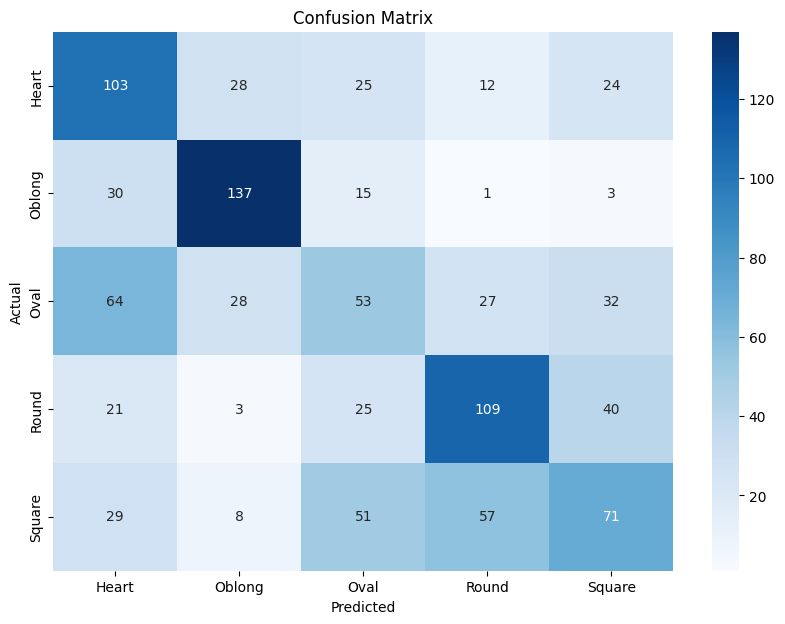

In [134]:
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [135]:
import joblib

# Assuming 'knn' is your trained KNN model
joblib.dump(knn, 'knn_face_shape_model.pkl')

['knn_face_shape_model.pkl']

In [136]:
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']